In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import sys
sys.path.insert(0, "../")

## Import

In [2]:
import pandas
import numpy

from sklearn.metrics import roc_curve, roc_auc_score

from rep.metaml import FoldingClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc

In [3]:
from utils import get_N_B_events, get_events_number, get_events_statistics

## Reading initial data

In [4]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('../datasets/MC/csv/Bu_JPsiK/Vertices.root', selection='(vcharge > 0.2)'))

In [5]:
data.head()

,run,event,No,mult,nnkrec,Bmass,ptB,vflag,ptmean,ipsmean,...,phi1,phi2,ghost1,ghost2,pointtheta,seedchi2,rdist,probf,v_cut,BOosc
0,2517778,1110824,0,21,4,5.27489,11.70600,4,0.940587,9.29878,...,1.363980,1.00376,0.050880,0.008245,0.142074,8.407050,2.06584,0.399833,0,0
1,2517778,1110824,1,21,4,5.27489,11.70600,3,1.172370,7.18694,...,2.336280,-2.36953,0.003858,0.002580,0.067733,0.062761,0.45721,0.903930,1,0
2,2517778,1110839,0,47,3,5.28328,3.88046,6,0.614212,13.12260,...,0.985463,2.26765,0.186784,0.006160,0.027074,3.467780,1.38931,0.805029,0,1
3,2517778,1110839,1,47,3,5.28328,3.88046,6,0.635548,14.23890,...,0.985463,2.72677,0.186784,0.002705,0.151040,2.414490,1.08309,0.896430,0,1
4,2517778,1110839,2,47,3,5.28328,3.88046,5,0.666694,12.26670,...,0.985463,1.38842,0.186784,0.098220,0.014452,0.220461,2.97054,0.921938,0,1


In [6]:
event_id_column = 'event_id'
event_id = data.run.apply(str) + '_' + data.event.apply(str)
data['group_column'] = numpy.unique(event_id, return_inverse=True)[1]

# all weights are 1, because this is MC
data['N_sig_sw'] = 1
data[event_id_column] = event_id

In [7]:
get_events_statistics(data)

{'Events': 602754, 'parts': 1802872}

In [8]:
import json
with open('../models/JPsiKMC.json', 'r') as f:
    N_B_events = json.load(f)['N_B_events']

In [9]:
N_B_events

1488891.0

In [10]:
N_pass = get_events_number(data)
tagging_efficiency = 1. * N_pass / N_B_events
tagging_efficiency_delta = sqrt(N_pass) / N_B_events
print tagging_efficiency, tagging_efficiency_delta

0.404834202101 0.000521443365133


### Define features

In [11]:
features =  ['mult', 'nnkrec', 'ptB', 'ipsmean', 'ptmean', 'vcharge', 
             'svm', 'svp', 'BDphiDir', 'svtau', 'docamax']
features_old =  ['mult', 'nnkrec', 'ptB', 'vflag', 'ipsmean', 'ptmean', 'vcharge', 
                'svm', 'svp', 'BDphiDir', 'svtau', 'docamax']

In [13]:
features_all = ['mult', u'nnkrec', u'ptB', 'ptmean', u'ipsmean', u'vcharge', u'svm', u'svp', u'BDphiDir',
                u'svtau', u'docamax',  u'massSeed', 'pt1', u'pt2', u'ips1', u'ips2', u'phi1', u'phi2', u'ghost1',
                u'ghost2', u'pointtheta', u'seedchi2', u'rdist', u'probf']

## Vertices sum of charges asymmetry

In [14]:
from utils import compute_sum_of_charges

In [15]:
old_mask = data.v_cut.values == 1

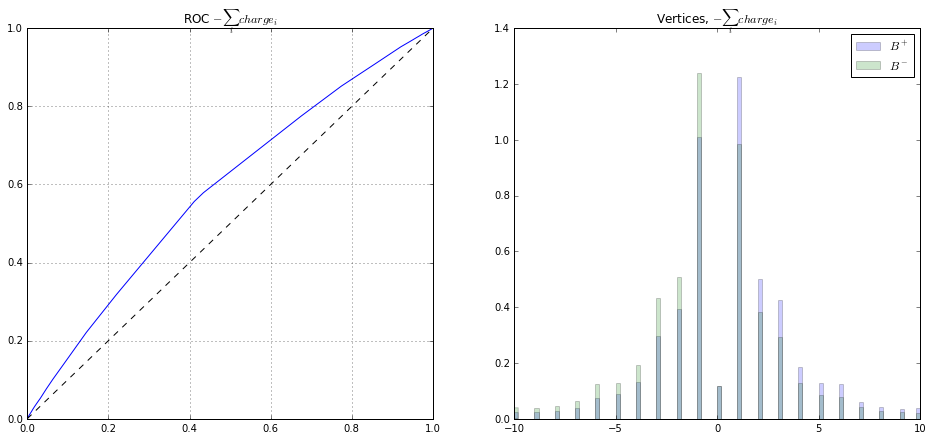

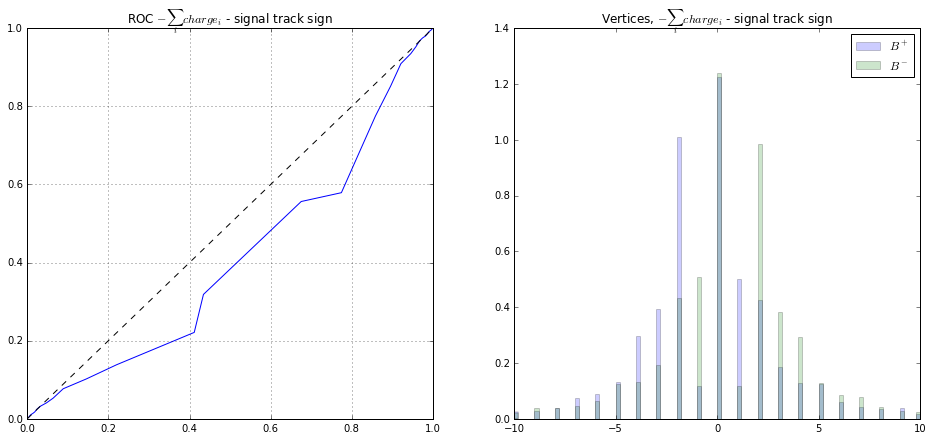

,$B^+$,"$B^+$, with signal part",$B^-$,"$B^-$, with signal part",ROC AUC,"ROC AUC, with signal part",name
0,0.511523,-0.488477,-0.571592,0.428408,0.586452,0.595232,Vertices


In [16]:
compute_sum_of_charges(data, 'Vertices', bins=100, 
                       event_id_column=event_id_column, sign_part_column='signVtx')

## Define label

In [17]:
data.loc[:, 'label'] = (data.signB.values * data.signVtx.values > 0) * 1

## DT

In [18]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from folding_group import FoldingGroupClassifier

In [19]:
data_sw_passed_lds = LabeledDataStorage(data, data.label.values)

In [21]:
tt_base = DecisionTrainClassifier(learning_rate=0.01, n_estimators=10000, depth=6,
                                  max_features=8, n_threads=12)
tt_folding = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                    train_features=features, group_feature='group_column')
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 21min 32s, sys: 3.22 s, total: 21min 35s
Wall time: 2min 36s


In [22]:
tt_folding_all = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                        train_features=features_all, group_feature='group_column')
%time tt_folding_all.fit_lds(data_sw_passed_lds)
pass

CPU times: user 20min 26s, sys: 3.61 s, total: 20min 30s
Wall time: 2min 32s


In [23]:
data_sw_passed_v_cut_lds = LabeledDataStorage(data.ix[old_mask, :], data.loc[old_mask, 'label'].values)
tt_folding_v_cut = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                          train_features=features_old, group_feature='group_column')
%time tt_folding_v_cut.fit_lds(data_sw_passed_v_cut_lds)
pass

CPU times: user 2min 52s, sys: 136 ms, total: 2min 52s
Wall time: 14.9 s


In [24]:
x = data.loc[old_mask, 'event_id'].values
data.index = data.event_id
data_sel = data.ix[x, :]

In [25]:
data_sw_passed_sp_lds = LabeledDataStorage(data_sel, data_sel['label'].values)
tt_folding_sp = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                       train_features=features, group_feature='group_column')
%time tt_folding_sp.fit_lds(data_sw_passed_sp_lds)
pass

CPU times: user 9min 27s, sys: 1.15 s, total: 9min 28s
Wall time: 59 s


In [26]:
report = ClassificationReport({'dt': tt_folding, 'dt with all features': tt_folding_all}, data_sw_passed_lds)

KFold prediction using folds column
KFold prediction using folds column


KFold prediction using folds column
KFold prediction using folds column


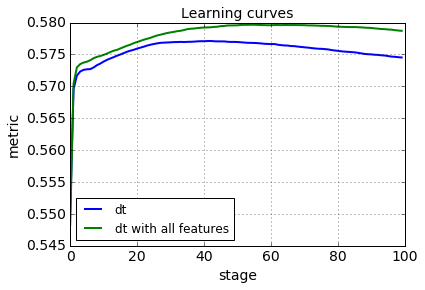

In [27]:
report.learning_curve(RocAuc(), steps=1)

In [28]:
report.compute_metric(RocAuc())

OrderedDict([('dt', 0.57453176203912371),
             ('dt with all features', 0.57871140021946177)])

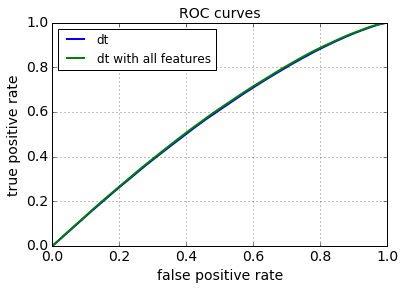

In [29]:
report.roc()

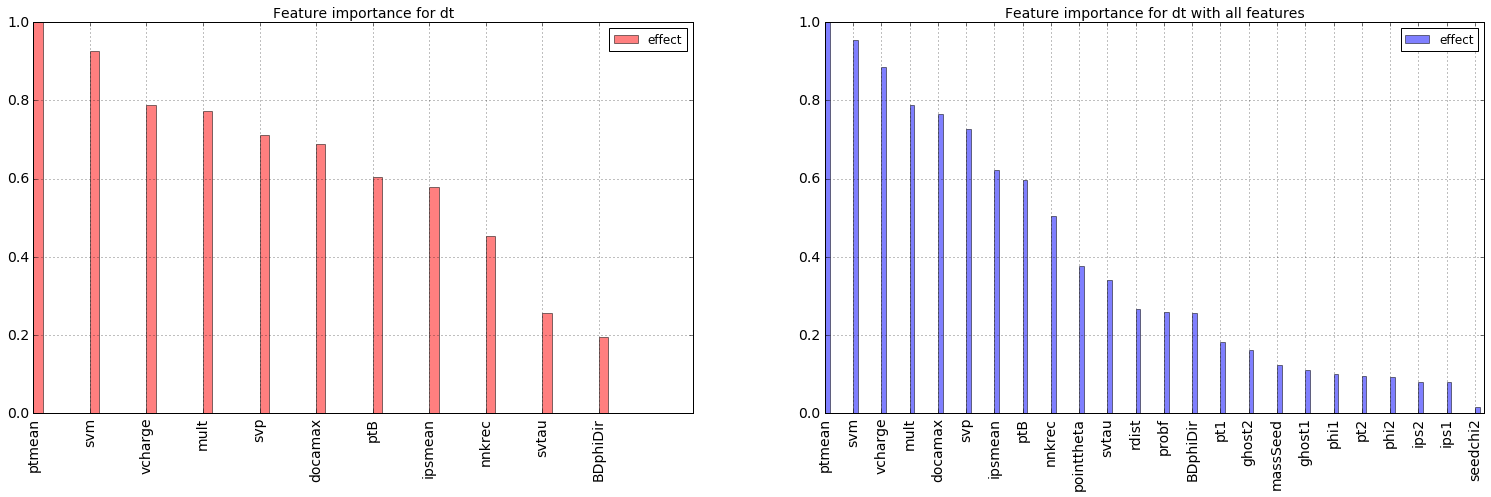

In [30]:
report.feature_importance()

In [31]:
tt_folding.estimators[0].clf.estimators = tt_folding.estimators[0].clf.estimators[:4000]
tt_folding.estimators[1].clf.estimators = tt_folding.estimators[1].clf.estimators[:4000]

In [32]:
tt_folding_all.estimators[0].clf.estimators = tt_folding_all.estimators[0].clf.estimators[:6000]
tt_folding_all.estimators[1].clf.estimators = tt_folding_all.estimators[1].clf.estimators[:6000]

In [33]:
report = ClassificationReport({'dt': tt_folding, 'dt with all features': tt_folding_all}, data_sw_passed_lds)

KFold prediction using folds column
KFold prediction using folds column


In [34]:
report.compute_metric(RocAuc())

OrderedDict([('dt', 0.57708235845060607),
             ('dt with all features', 0.57958965278153052)])

In [35]:
report_v_cut = ClassificationReport({'tt': tt_folding_v_cut}, data_sw_passed_v_cut_lds)

KFold prediction using folds column


KFold prediction using folds column


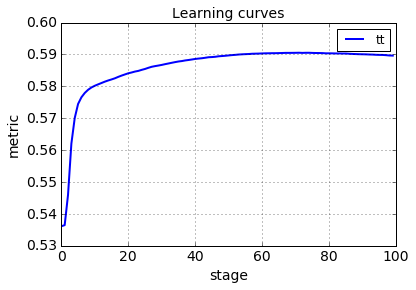

In [36]:
report_v_cut.learning_curve(RocAuc(), steps=1)

In [38]:
report_v_cut.compute_metric(RocAuc())

OrderedDict([('tt', 0.58964954257530666)])

In [39]:
tt_folding_v_cut.estimators[0].clf.estimators = tt_folding_v_cut.estimators[0].clf.estimators[:7000]
tt_folding_v_cut.estimators[1].clf.estimators = tt_folding_v_cut.estimators[1].clf.estimators[:7000]

KFold prediction using folds column
KFold prediction using folds column


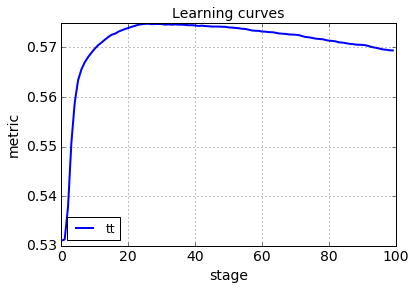

In [40]:
report_sp = ClassificationReport({'tt': tt_folding_sp}, data_sw_passed_sp_lds)
report_sp.learning_curve(RocAuc(), steps=1)

In [41]:
report_sp.compute_metric(RocAuc())

OrderedDict([('tt', 0.56937902351359659)])

In [42]:
tt_folding_sp.estimators[0].clf.estimators = tt_folding_sp.estimators[0].clf.estimators[:3000]
tt_folding_sp.estimators[1].clf.estimators = tt_folding_sp.estimators[1].clf.estimators[:3000]

--------

## Calibrating results $p(\text{vrt same sign}|B)$ and combining them

In [43]:
N_pass_v_cut = get_events_number(data.ix[old_mask, :])
tagging_efficiency_v_cut = 1. * N_pass_v_cut / N_B_events
tagging_efficiency_delta_v_cut = sqrt(N_pass_v_cut) / N_B_events
print tagging_efficiency_v_cut, tagging_efficiency_delta_v_cut

0.122650348481 0.000287013907194


In [44]:
models = []

In [45]:
from utils import get_result_with_bootstrap_for_given_part

KFold prediction using folds column


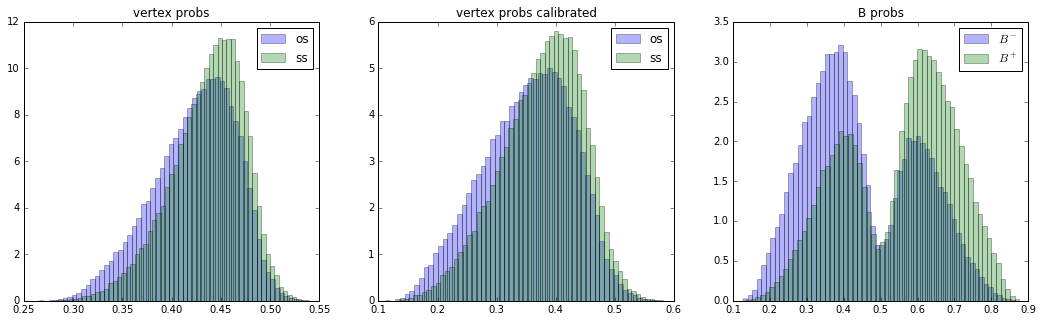

AUC for tagged: 0.680693059598 AUC with untag: 0.532496481933


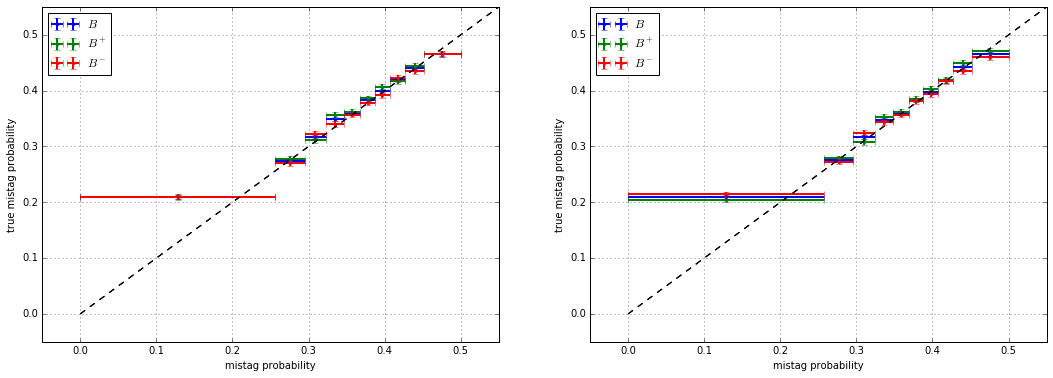

mean AUC after calibration: 0.680680269261 2.50021693792e-10


In [46]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency_v_cut, tagging_efficiency_delta_v_cut, 
                                                       tt_folding_v_cut, 
                                                      [data.ix[old_mask, :]], N_B_events=N_B_events,
                                                      logistic=True, name="old tagging", n_calibrations=30,
                                                      sign_part_column='signVtx', part_name='vertex',
                                                      logistic_combined=True))

KFold prediction using folds column


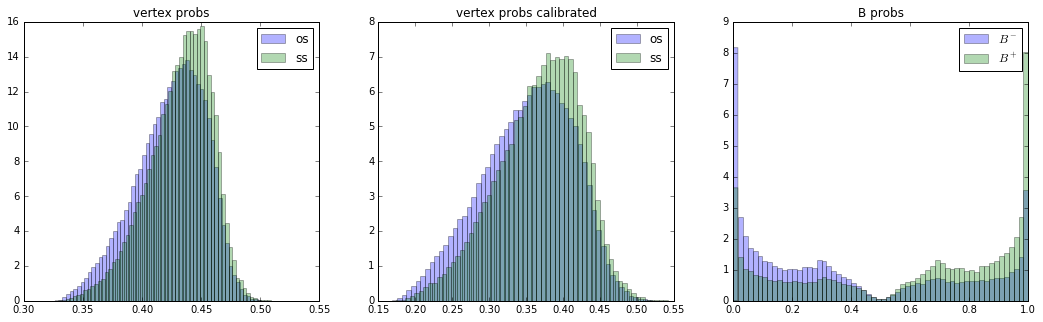

AUC for tagged: 0.660196489267 AUC with untag: 0.532414448103


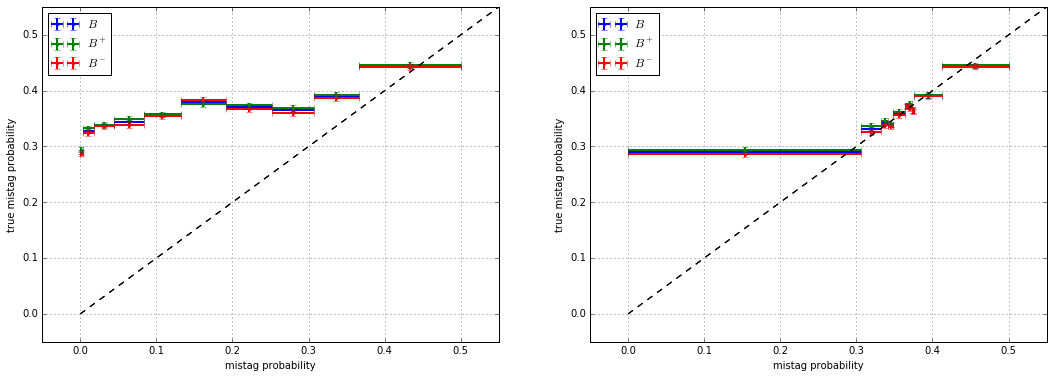

mean AUC after calibration: 0.660221103363 1.37338872024e-08


In [48]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency_v_cut, tagging_efficiency_delta_v_cut, 
                                                       tt_folding_sp, 
                                                      [data_sel], N_B_events=N_B_events,
                                                      logistic=True, name="inclusive vertex with selection",
                                                       n_calibrations=30,
                                                      sign_part_column='signVtx', part_name='vertex',
                                                      logistic_combined=False))

KFold prediction using folds column


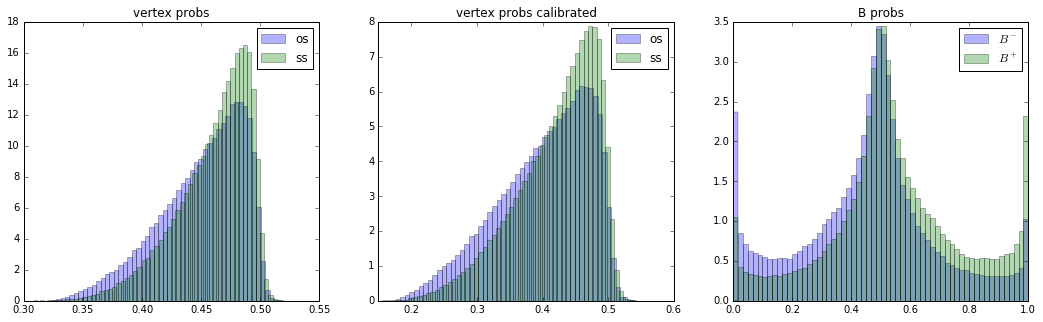

AUC for tagged: 0.606196703067 AUC with untag: 0.5534348621


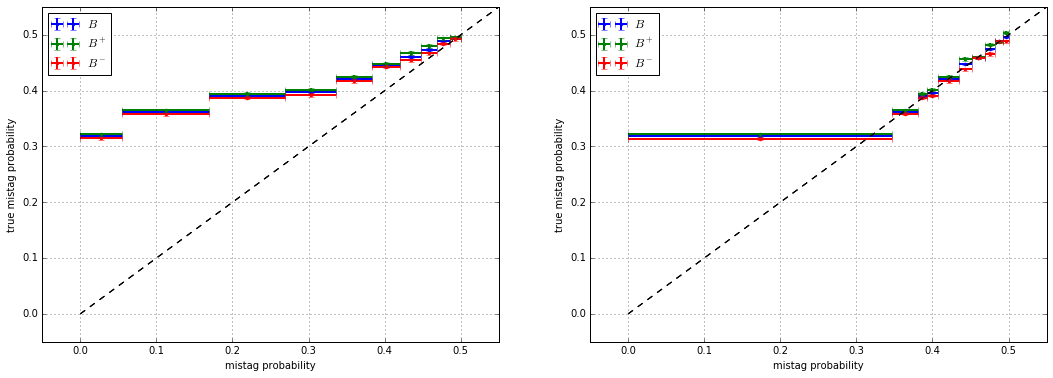

mean AUC after calibration: 0.606090879124 1.59221067884e-09


In [49]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data], N_B_events=N_B_events,
                                                      logistic=True, name="inclusive vertex", n_calibrations=30,
                                                      sign_part_column='signVtx', part_name='vertex', 
                                                      logistic_combined=False))
              

KFold prediction using folds column


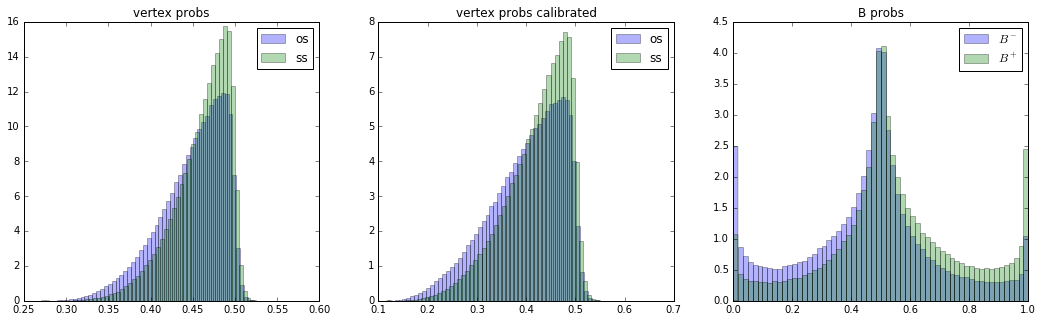

AUC for tagged: 0.60746652492 AUC with untag: 0.553594994119


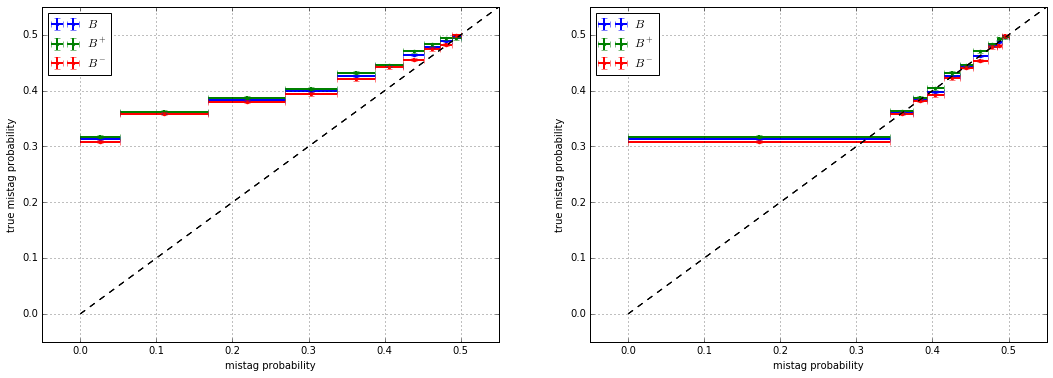

mean AUC after calibration: 0.607332146606 1.33999925542e-09


In [50]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding_all, 
                                                      [data], N_B_events=N_B_events,
                                                      logistic=True, name="inclusive vertex, all features",
                                                       n_calibrations=30,
                                                      sign_part_column='signVtx', part_name='vertex', 
                                                       logistic_combined=False))

# Comparison of different models

In [54]:
pandas.concat(models)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,old tagging,12.265035,0.028701,0.099689,0.000457,1.222695,0.006297,53.249648,0
0,inclusive vertex with selection,12.265035,0.028701,0.084445,0.000039,1.035725,0.002471,53.241445,0
0,inclusive vertex,40.483420,0.052144,0.035009,0.000018,1.417284,0.001962,55.343486,0
0,"inclusive vertex, all features",40.483420,0.052144,0.036065,0.000015,1.460018,0.001971,55.359499,0


----------------------

# experiments of grouping vertices in event

In [55]:
from utils import group_max
from scipy.special import logit, expit
from utils import compute_B_prob_using_part_prob
from utils import calculate_auc_with_and_without_untag_events
from utils import compute_mistag
from utils import calibrate_probs, bootstrap_calibrate_prob, result_table

percentile_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

In [56]:
def estimate_events(Bsign, Bweight, Bprob, Bevent, tagging_efficiency, tagging_efficiency_delta, name):
    auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprob, Bweight, N_B_events=N_B_events)
    print auc, auc_full
    D2, aucs = bootstrap_calibrate_prob(Bsign, Bweight, Bprob, 
                                        n_calibrations=30, symmetrize=True, logistic=False)
#     Bprob_calibrated, (iso_reg1, iso_reg2) = calibrate_probs(Bsign, Bweight, Bprob,
#                                                              symmetrize=True, return_calibrator=True, logistic=True)
    return result_table(tagging_efficiency, tagging_efficiency_delta, D2, auc_full, name)

## max of vertices

In [57]:
data['p_vertex'] = tt_folding_all.predict_proba(data)[:, 1] + 1e-8*numpy.random.random(len(data))
max_events = group_max(data.group_column.values, data['p_vertex'].values)
min_events = -group_max(data.group_column.values, -data['p_vertex'].values)
p_events = numpy.where(abs(max_events - 0.5) > abs(min_events - 0.5), max_events, min_events)

KFold prediction using folds column


In [58]:
data_events = data.ix[abs(p_events - data.p_vertex.values) < 1e-14, :]
data_probs = p_events[abs(p_events - data.p_vertex.values) < 1e-14]

In [59]:
len(data_probs), len(numpy.unique(data.group_column))

(602754, 602754)

In [60]:
Bsign, Bweight, Bprob, Bevent = compute_B_prob_using_part_prob(data_events, data_probs, sign_part_column='signVtx')

0.612419732062 0.554796084468


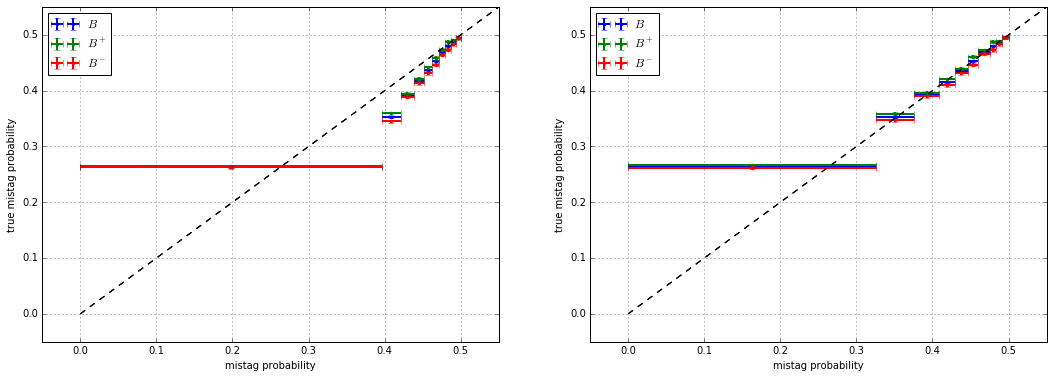

In [61]:
t = estimate_events(Bsign, Bweight, Bprob, Bevent, tagging_efficiency, 
                    tagging_efficiency_delta, 'inclusive vertex, max val, all features')

In [63]:
t

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"inclusive vertex, max val, all features",40.48342,0.052144,0.043157,0.000016,1.747161,0.002341,55.479608,0


In [64]:
x_pd_max = pandas.DataFrame({'event_id': data_events.event_id,
                  'Bweight': numpy.ones(len(data_events)),
                  'Bsign': data_events.signB, 
                  'vertex_relation_prob': Bprob / (1 - Bprob)})

In [65]:
x_pd_max.to_csv('../models/Bdata_vertex_MC_max.csv', header=True, index=False)

## mean of logits

In [66]:
# mean predictions
p_mean = expit(numpy.bincount(data.group_column, weights=logit(data.p_vertex.values) * data.signVtx) / numpy.bincount(data.group_column))
p_svertex = numpy.ones(len(p_mean))

In [67]:
Bsign, Bweight, Bprob, Bevent = compute_B_prob_using_part_prob(pandas.DataFrame({
                                                                'signVtx': p_svertex,
                                                               'event_id': numpy.arange(len(p_svertex)),
                                                               'N_sig_sw': numpy.ones(len(p_svertex)),
                                                                'signB': numpy.bincount(data.group_column, weights=data.signB) / numpy.bincount(data.group_column)}), 
                                                                 p_mean, sign_part_column='signVtx')

0.611382346187 0.554328667627


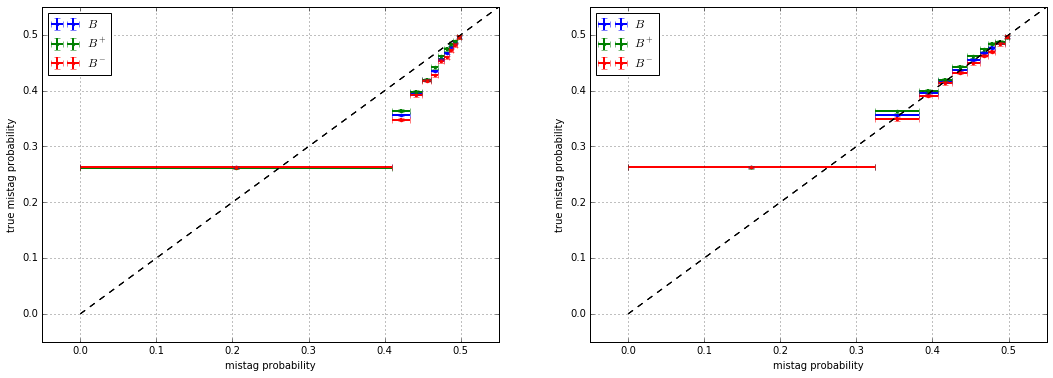

In [68]:
t_mean = estimate_events(Bsign, Bweight, Bprob, Bevent, tagging_efficiency, 
                         tagging_efficiency_delta, 'inclusive vertex, mean, all features')

In [69]:
run_all = map(int, numpy.bincount(data.group_column, weights=data.run) // numpy.bincount(data.group_column))
event_all = map(int, numpy.bincount(data.group_column, weights=data.event) // numpy.bincount(data.group_column))
x = pandas.DataFrame({'run': run_all, 'event': event_all})

In [70]:
x_pd = pandas.DataFrame({'event_id': x.run.apply(str) + '_' + x.event.apply(str),
                  'Bweight': numpy.ones(len(p_svertex)),
                  'Bsign': numpy.bincount(data.group_column, weights=data.signB) / numpy.bincount(data.group_column), 
                  'vertex_relation_prob': p_mean / (1 - p_mean)})

In [71]:
x_pd.to_csv('../models/Bdata_vertex_MC_sqrt.csv', header=True, index=False)

In [72]:
pandas.concat(models + [t, t_mean])

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,old tagging,12.265035,0.028701,0.099689,0.000457,1.222695,0.006297,53.249648,0
0,inclusive vertex with selection,12.265035,0.028701,0.084445,0.000039,1.035725,0.002471,53.241445,0
0,inclusive vertex,40.483420,0.052144,0.035009,0.000018,1.417284,0.001962,55.343486,0
0,"inclusive vertex, all features",40.483420,0.052144,0.036065,0.000015,1.460018,0.001971,55.359499,0
0,"inclusive vertex, max val, all features",40.483420,0.052144,0.043157,0.000016,1.747161,0.002341,55.479608,0
0,"inclusive vertex, mean, all features",40.483420,0.052144,0.042633,0.000011,1.725921,0.002265,55.432867,0
